In [7]:
import os, sys
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy import units
from tqdm import tqdm_notebook
from lightkurve.lightcurve import LightCurve
from scipy.interpolate import interp1d

from costools import timefilter, splittag
import calcos

%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src')
from cos_reduction import *
from utils import *

## PROPOSAL ID 16164
plt.rcParams['font.size']=24

rootname = ['lebb01s7q', 'lebb01sbq', 'lebb01sdq', 'lebb01siq', 'lebb01smq']
rootname = ['lebb03xpq', 'lebb03xrq', 'lebb03xtq', 'lebb03xvq', 'lebb03xxq']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cr = cosReduce(rootname=rootname, 
               input_path='/Users/arcticfox/Documents/AUMic/rawfiles/')

In [ ]:
cr.split_corrtag(output_path='/Users/arcticfox/Documents/AUMic/20s/splittag2', increment=30)

In [ ]:
cr.check_ref_files(path='/Users/arcticfox/Documents/AUMic/lref/')

In [ ]:
cr.reduce_data(output_path='/Users/arcticfox/Documents/AUMic/20s/reduced2')

In [3]:
cr.path_a = '/Users/arcticfox/Documents/AUMic/30s/reduced2/a'
cr.path_b = '/Users/arcticfox/Documents/AUMic/30s/reduced2/b'
cr.bookkeeping()

In [5]:
cr.interpolate(offset=0.03)
#cr.bin()
np.save('/Users/arcticfox/Documents/AUMic/30s/reduced2/data_a.npy', [cr.wavelength,
                                                                         cr.flux,
                                                                         cr.flux_err])
#cr.interpolate()
#cr.bin()
#np.save('/Users/arcticfox/Documents/AUMic/20s/reduced/data_b.npy', [cr.wavelength,
#                                                                         cr.flux,
#                                                                         cr.flux_err])

In [ ]:
np.save('/Users/arcticfox/Documents/AUMic/20s/reduced/orbits.npy', cr.orbit)

In [ ]:
np.save('/Users/arcticfox/Documents/AUMic/20s/reduced/times.npy', cr.times)

## Visit 2 reduction

In [ ]:
cr.split_corrtag(output_path='/Users/arcticfox/Documents/AUMic/20s/splittag2', increment=20)

In [ ]:
cr.check_ref_files(path='/Users/arcticfox/Documents/AUMic/lref/')

In [ ]:
cr.reduce_data(output_path='/Users/arcticfox/Documents/AUMic/20s/reduced2')

In [ ]:
cr.bookkeeping()

In [ ]:
cr.interpolate()
#cr.bin()
np.save('/Users/arcticfox/Documents/AUMic/20s/reduced2/data_a.npy', [cr.wavelength,
                                                                         cr.flux,
                                                                         cr.flux_err])
cr.interpolate()
#cr.bin()
np.save('/Users/arcticfox/Documents/AUMic/20s/reduced2/data_b.npy', [cr.wavelength,
                                                                         cr.flux,
                                                                         cr.flux_err])

In [ ]:
np.save('/Users/arcticfox/Documents/AUMic/20s/reduced/2orbits.npy', cr.orbit)
np.save('/Users/arcticfox/Documents/AUMic/20s/reduced2/times.npy', cr.times)

## Better calibration of wavelength

cross-correlating to find the wavelength offset between visits

In [ ]:
from scipy.signal import correlate2d, correlate, correlation_lags
from specutils import analysis, Spectrum1D
from specutils.analysis import template_correlate
from astropy.nddata import StdDevUncertainty

In [ ]:
path1 = '/Users/arcticfox/Documents/AUMic/30s/reduced/a'
files1 = np.sort([os.path.join(path1,i) for i in os.listdir(path1) if i.endswith('x1d.fits')])

path2 = '/Users/arcticfox/Documents/AUMic/30s/reduced2/a'
files2 = np.sort([os.path.join(path2,i) for i in os.listdir(path2) if i.endswith('x1d.fits')])

In [ ]:
for i in tqdm_notebook(range(len(files1))):
    hdu = fits.getdata(files1[i])
    wc = np.append(hdu['wavelength'][1], hdu['wavelength'][0])
    fx = np.append(hdu['flux'][1], hdu['flux'][0])
    er = np.append(hdu['error'][1], hdu['error'][0])
    if i == 0:
        wave1 = np.zeros((len(files1), len(wc)))
        flux1 = np.zeros((len(files1), len(wc)))
        err1 = np.zeros((len(files1), len(wc)))
    wave1[i] = wc
    flux1[i] = fx
    err1[i]  = er

In [ ]:
for i in tqdm_notebook(range(len(files2))):
    hdu = fits.getdata(files2[i])
    wc = np.append(hdu['wavelength'][1], hdu['wavelength'][0])
    fx = np.append(hdu['flux'][1], hdu['flux'][0])
    er = np.append(hdu['error'][1], hdu['error'][0])
    if i == 0:
        wave2 = np.zeros((len(files2), len(wc)))
        flux2 = np.zeros((len(files1), len(wc)))
        err2 = np.zeros((len(files1), len(wc)))
    wave2[i] = wc
    flux2[i] = fx
    err2[i]  = er

In [ ]:
def fit_maximum(x, y):
    fit = np.polyfit(x, y, deg=2)
    return fit

In [ ]:
corr = np.correlate(np.nanmean(flux1,axis=0) - np.nanmedian(np.nanmean(flux1,axis=0)), 
                    np.nanmean(flux2,axis=0) - np.nanmedian(np.nanmean(flux2,axis=0)), 
                    mode='same')
c = np.arange(np.argmax(corr)-4, np.argmax(corr)+5,1,dtype=int)

fit = fit_maximum(c-np.argmax(corr), corr[c])
maximum = -fit[1]/(2*fit[0]) 

In [ ]:
corr = correlate(np.nanmean(flux1,axis=0) - np.nanmedian(np.nanmean(flux1,axis=0)), 
                    np.nanmean(flux2,axis=0) - np.nanmedian(np.nanmean(flux2,axis=0)))
lags = correlation_lags(len(np.nanmean(flux1,axis=0)),
                        len(np.nanmean(flux2,axis=0)))

In [ ]:
corr, lag = template_correlate(spect1, spect2)

In [ ]:
wave_range = [np.nanmax(wave1[:,0]), np.nanmax(wave2[:,-1])]

In [ ]:
interp1 = interp1d(wave1[0], flux1[0])
q = (wave2[0]>wave_range[0]) & (wave2[0]<wave_range[-1])
interp1(wave2[0][q])

In [ ]:
plt.plot(np.nanmedian(wave1,axis=0), np.nanmean(flux1,axis=0))
plt.plot(np.nanmedian(wave2,axis=0)-0.03, np.nanmean(flux2,axis=0))
plt.xlim(1263.738,1265.738)
plt.ylim(1e-15,0.4e-13)

## Checking binning

In [22]:
def load_data(path):
    wavelength, flux, err = load_binned_data(os.path.join(path,'data_a.npy'))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w20, f20, e20, t20, o20 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced')
w30, f30, e30, t30, o30 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced2')

(1e-15, 4e-14)

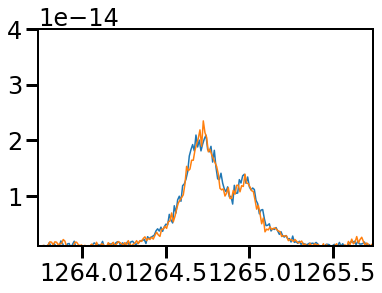

In [25]:
plt.plot(w20[0], np.nanmean(f20, axis=0))
plt.plot(w30[0]-0.06, np.nanmean(f30, axis=0))
plt.xlim(1263.738,1265.738)
plt.ylim(1e-15,0.4e-13)

In [36]:
new_wave = np.linspace(w20[0][1], w30[0][-2]-0.06,len(w20[0]))

In [42]:
nf1, nf2 = np.zeros(f20.shape), np.zeros(f30.shape)
ne1, ne2 = np.zeros(f20.shape), np.zeros(f30.shape)

for i in tqdm_notebook(range(len(w20))):
    interp1 = interp1d(w20[i], f20[i])
    interp2 = interp1d(w30[i]-0.06, f30[i])
    
    nf1[i] = interp1(new_wave)
    nf2[i] = interp2(new_wave)
    
    interp1 = interp1d(w20[i], e20[i])
    interp2 = interp1d(w30[i]-0.06, e30[i])
    
    ne1[i] = interp1(new_wave)
    ne2[i] = interp2(new_wave)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/402 [00:00<?, ?it/s]

(1e-15, 4e-14)

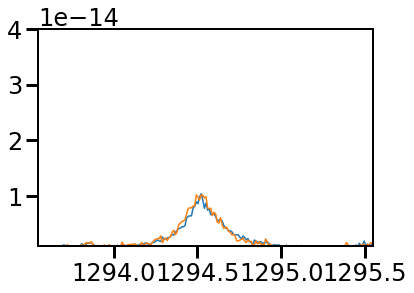

In [41]:
plt.plot(new_wave, np.nanmean(nf1, axis=0))
plt.plot(new_wave, np.nanmean(nf2, axis=0))
plt.xlim(1294.548-1,1294.548+1)
plt.ylim(1e-15,0.4e-13)

In [44]:
np.save('/Users/arcticfox/Documents/AUMic/30s/reduced/interp_between_1.npy',
        [np.full(w20.shape, new_wave), nf1, ne1])
np.save('/Users/arcticfox/Documents/AUMic/30s/reduced2/interp_between_1.npy',
        [np.full(w30.shape, new_wave), nf2, ne2])